Create a library of randomly generated non-linear functions. These are to be estimated a) with all possible kernels in the library or b) with exponential kernels only (this will probably present a problem with extrapolation). Of course, we are talking only about 1-layer realtionship, because we don't do deep learning.

The random functions are to be estimated from a given set of kernels, and will be constructed from multiple data views (design matrices). Do we know these groupings in practice? Possibly. Should the scope of a function be limited to within the dataset only? Yes. 

What about the generation of weights? This is important to argue the MKL part. They are to be generated along with the function and stored in the same object.

Can a data view be sampled multiple times? No, because this will heavily obstruct the evaluation.

For each term in the *sum* we randomly sample:
- A data view
- A subset of indices of the data view's columns. These will be part of an aggregation function.
- A function family to operate on the data view.


A similar experiment shall be repeated for the case where functions are performed on the same data view (possibly using all incides), but with kernels with different hyperparameters.

A similar experiment can be done when the signals are generate from a sum of kernels with different weights and regression is performed wia dual coefficients. The, we should use the relationship between primal and dual weights to compare the values. Again, repeat for the cases where function family is known and unknown.

How to treat different values of hyperparameters? Maybe the solution is something like grid search, trying with multiple kernel functions with different hyperparameters.

In [1]:
from examples.functions import MultiKernelFunction
from scipy.stats import chi2
import numpy as np

from mklaren.mkl.mklaren import Mklaren
from mklaren.regression.ridge import RidgeLowRank
from mklaren.kernel.kinterface import Kinterface
import itertools as it

import sklearn.metrics as skm
mse = skm.mean_squared_error

% matplotlib inline
import matplotlib.pyplot as plt

In [70]:
# Input dimension
P = 3
p = 10
n = 300

# Data is generated randomly
X = np.random.randn(n, p)

# Dual coefficients are non-negative
alpha = np.array([np.random.randn() for i in range(n)])

mf = MultiKernelFunction(P)
y = mf(X, alpha)
y = y - y.mean()

# Error of mean predictions
rmse0 = (mse(y, np.zeros((n,))) / n) **0.5

In [71]:
# Fit this data using Mklaren
mkl = Mklaren(delta=3, rank=12, lbd=0)
Ks = [Kinterface(X, kernel=f) for (_, (f, _)) 
      in sorted(MultiKernelFunction.library.items())]
mkl.fit(Ks, y)
ypm = mkl.predict([X, X, X])

rmse2 = (mse(y, ypm) / n) ** 0.5

print("Mklaren model RMSE: %f, mean RMSE: %f. \n" % (rmse2, rmse0))
print("Functional form:")
print(mf)

Mklaren model RMSE: 8193.970412, mean RMSE: 9024.341606. 

Functional form:
y = 
	 2.11e-02 lin(x, x, ) + 
	 1.62e-01 poly(x, x, p=5.00, b=-3.00) + 
	 7.61e-03 exp(x, x, gamma=35.94)


Compare approximated and true weights from different families. 
The functions use different hyper parameters, hence the discrepancy.

In [72]:
print(sorted(MultiKernelFunction.library.keys()))
print(mkl.mu)

['exp', 'lin', 'poly']
[       0.                0.          2839816.69588843]


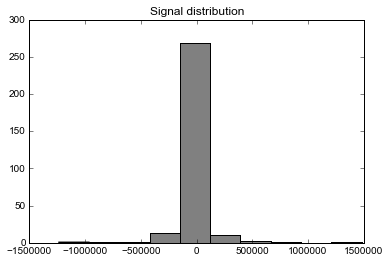

In [73]:
plt.figure()
plt.hist(y, color="gray")
plt.title("Signal distribution")
plt.show()

In [74]:
# Generate a target set of kernels in the library with all possible values of hyperparameters
lib = MultiKernelFunction.library
vals = MultiKernelFunction.values

Ks = []
for name, (f, pars) in lib.items():
    if len(pars):
        for p in pars:
            for v in vals[p]:
                k = Kinterface(data=X, kernel=f, kernel_args={p: v})
                Ks.append(k)
    else:
        k = Kinterface(data=X, kernel=f)
        Ks.append(k)

Fit the MKL model to data and inspect weights.

In [75]:
mkl = Mklaren(delta=12, rank=10, lbd=0)
mkl.fit(Ks, y)

In [76]:
mu = mkl.mu
inxs = mkl.mu.nonzero()[0]
for i in inxs:
    print Ks[i].kernel, Ks[i].kernel_args, mu[i]

<function poly_kernel at 0x10e7e88c0> {'p': 2} 205826.497301
<function poly_kernel at 0x10e7e88c0> {'p': 3} 2127942.73785
<function poly_kernel at 0x10e7e88c0> {'p': 4} 42095.9972035
<function poly_kernel at 0x10e7e88c0> {'p': 5} 1365293.45226
<function poly_kernel at 0x10e7e88c0> {'b': -3.0} 162991.413699
<function exponential_kernel at 0x10e7e89b0> {'gamma': 0.01} 505120.701006
